In [1]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import pyplot
import matplotlib.gridspec as gridspec

from PIL import Image


from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.table import Table
from astropy.visualization import quantity_support
from astropy.coordinates import SkyCoord
from astropy.time import Time

import pandas as pd
import urllib.request as ureq

from pypeit.specutils import Spectrum1D
from pypeit.specutils import SpectrumList
from pypeit.core import wave

import numpy as np
from glob import glob
import os

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

## Gal em

In [2]:
url = 'https://classic.sdss.org/dr6/algorithms/linestable.php'

uf = ureq.urlopen(url)
html = uf.read()

tables = pd.read_html(str(url), flavor='html5lib',header=1)[0]

In [3]:
lines = tables.iloc[1:37]
lines['Galaxy'] = lines['Galaxy'].astype(float)
lines['vac (Å)'] = lines['vac (Å)'].astype(float)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (214283649.py:2)
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (214283649.py:3)


In [4]:
gal_em = lines[lines['Galaxy']>0]
gal_em['SPECIES'] = ['Mg II', 'O II', r'H$\Delta$', r'H$\gamma$', r'H$\beta$', 'O III', 'O III', 'N II', r'H$\alpha$','N II', 'S II', 'S II']
tmp = pd.DataFrame({'vac (Å)':[3729],'Galaxy':[1],'Quasar':[0],'SPECIES':['O II']})
gal_em = pd.concat((gal_em,tmp)).reset_index(drop=True)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy (4132517119.py:2)


In [5]:
gal_em

vac (Å)  Galaxy Quasar    SPECIES
0   2799.117     1.0    8.0      Mg II
1   3727.092     5.0    1.0       O II
2   4102.890     0.5    2.0  H$\Delta$
3   4341.680     1.0    3.0  H$\gamma$
4   4862.680     2.0    4.0   H$\beta$
5   4960.295     2.0    2.0      O III
6   5008.240     3.0    2.0      O III
7   6549.860     3.0    0.0       N II
8   6564.610     8.0    8.0  H$\alpha$
9   6585.270     3.0    0.0       N II
10  6718.290     3.0    0.0       S II
11  6732.670     3.0    0.0       S II
12  3729.000     1.0      0       O II

In [6]:
os.getcwd()

'/home/tamar/findinglens/keck'

In [7]:
smallsmth = 3
bigsmth = 12

## DESI-004 (z=1.832)

In [8]:
desi004_c = sorted(glob('2023-11-21/DESI-004/reducing_folder/keck_nires_A/*DESI*'))

desi_004_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_004_cutout.png'
desi_004_img_path = '/home/tamar/findinglens/keck/plot_images/desi_004_img.png'

desi004_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi004_2dspec_coadd.fits'

desi004_hst_img = np.asarray(Image.open(desi_004_img_path))
desi004_legacy_cutout = np.asarray(Image.open(desi_004_dr9_path))
desi004_spec2d = fits.getdata(desi004_spec2d_p)



In [9]:
coad_spec = Spectrum1D.read(desi004_c[0], strict=False)


smth = bigsmth
z = 1.832
redshifted = gal_em[['vac (Å)']] 


wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

smth = smallsmth

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!


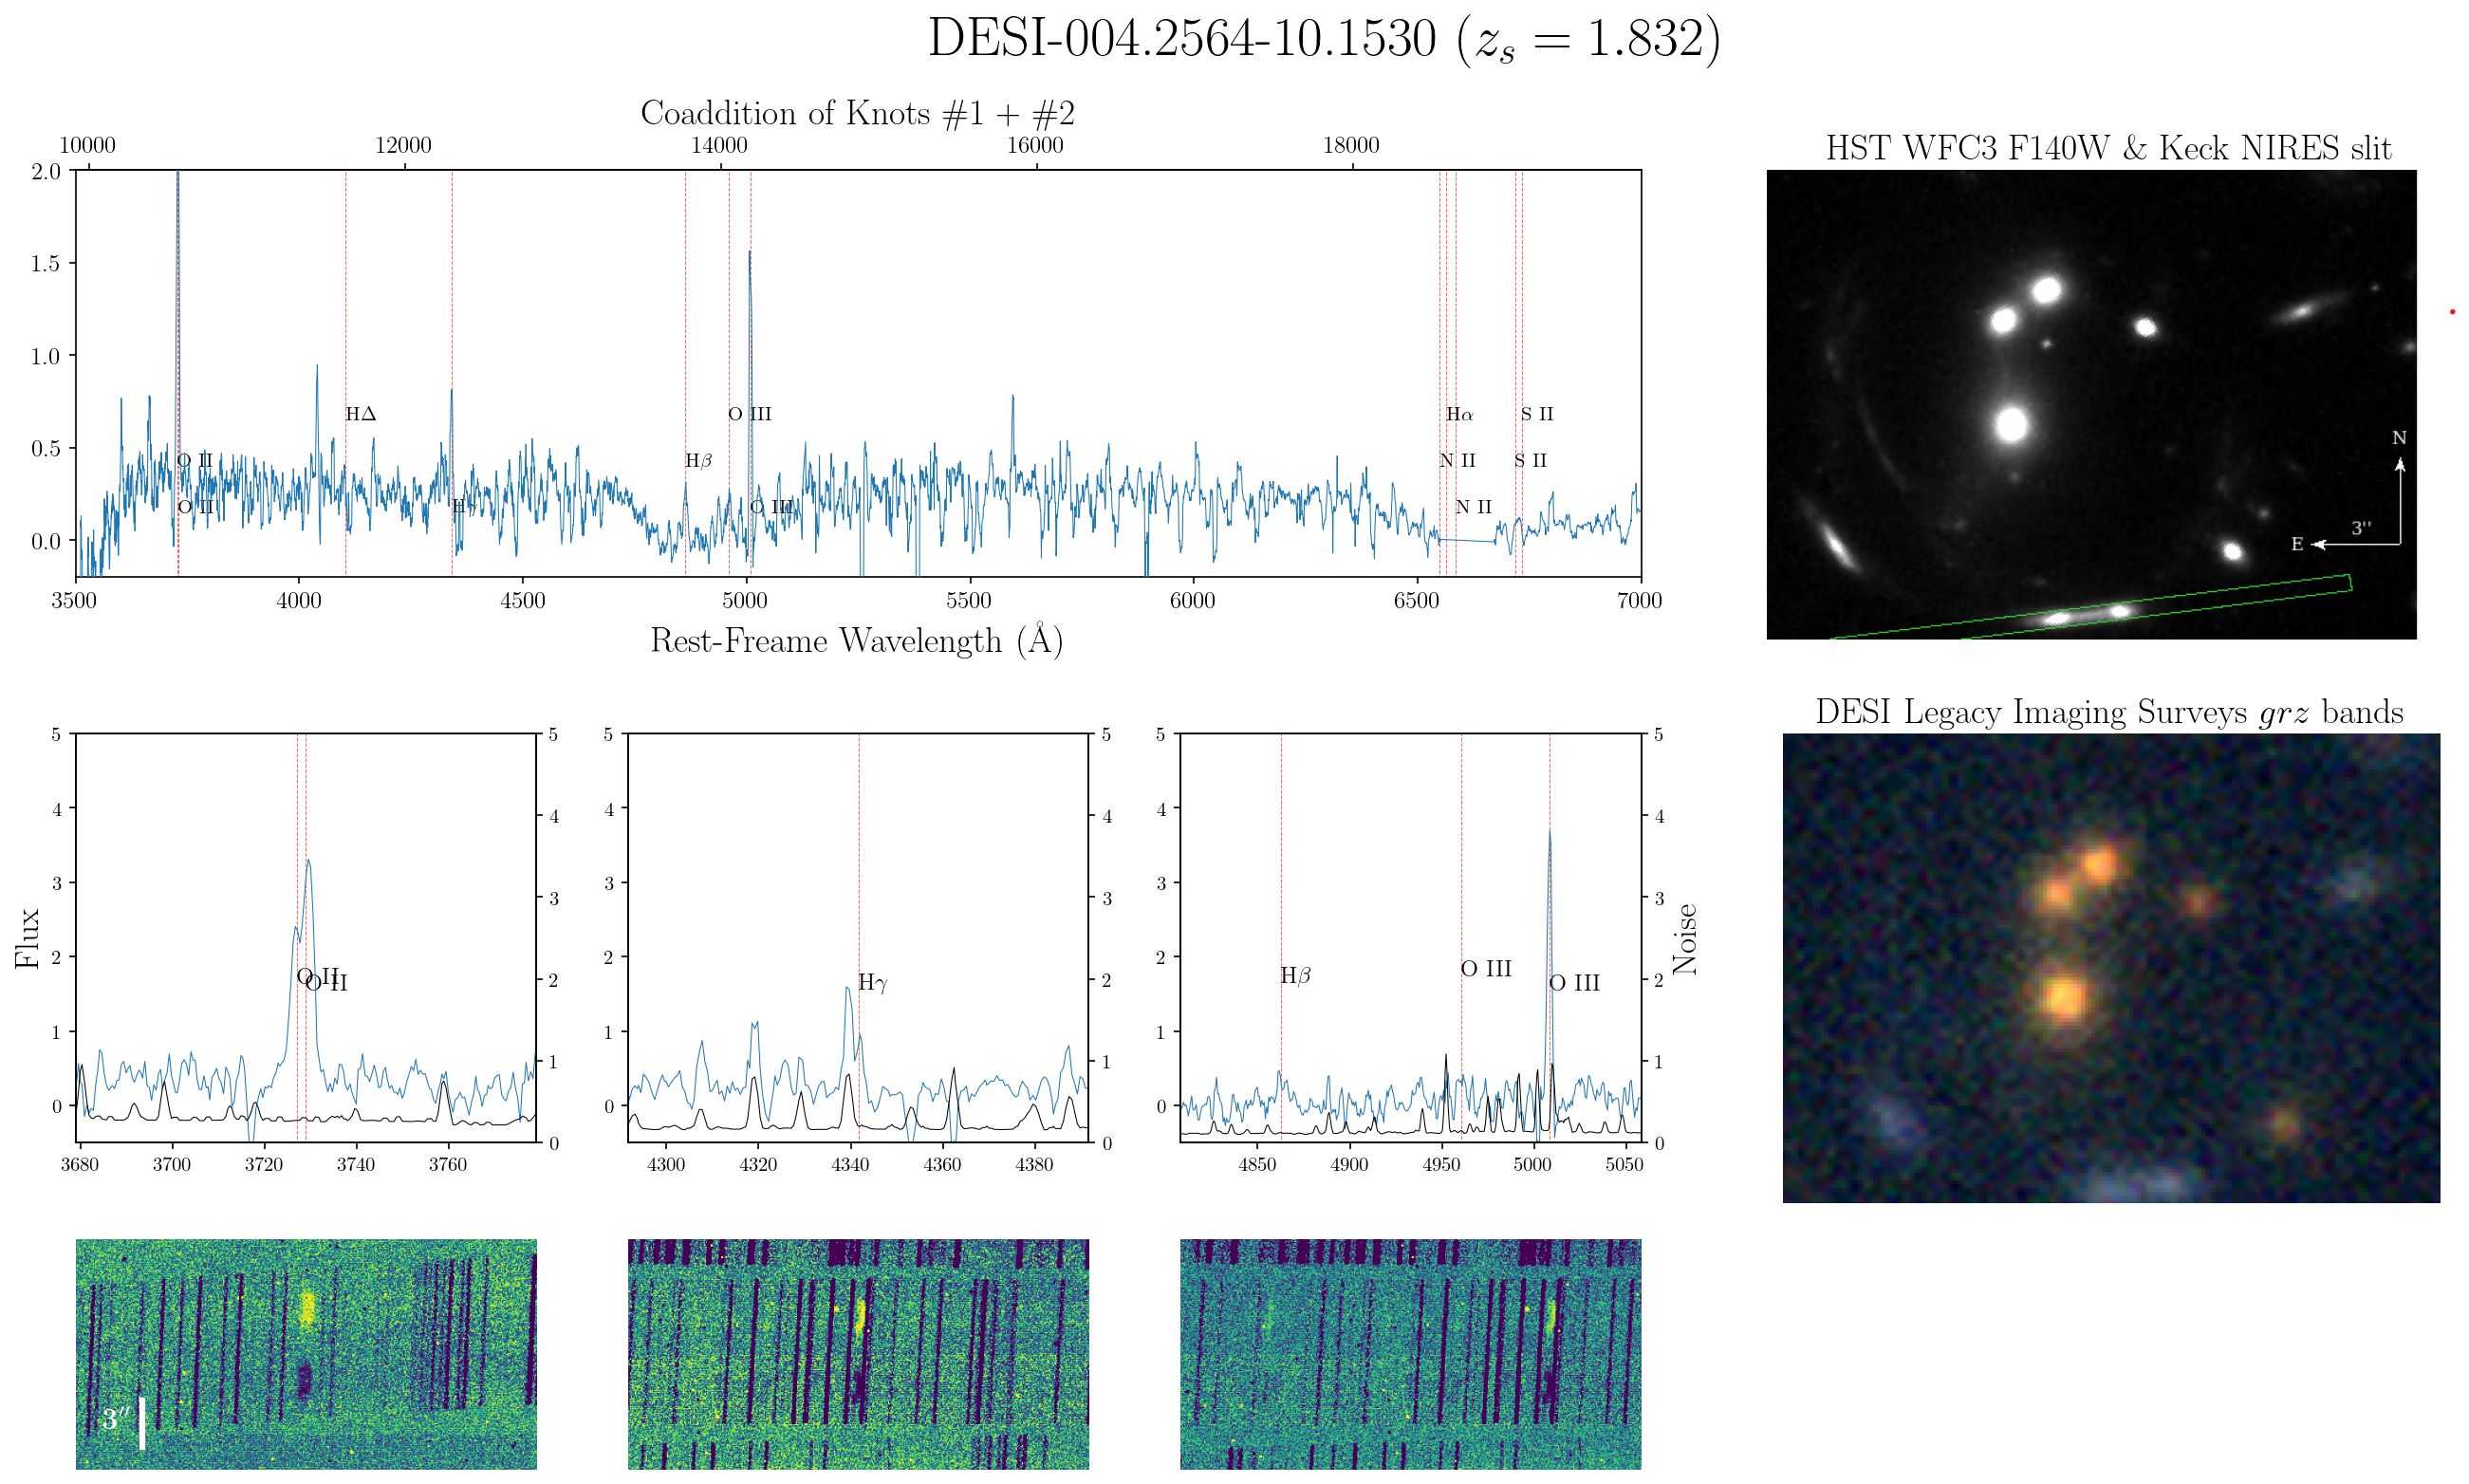

In [10]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(1,4, figure=fig, top=0.93, bottom=0.80, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-004.2564-10.1530 ($z_s = 1.832$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])

f_ax1.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 2)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax1.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################
gs2 = fig.add_gridspec(17,17, top=0.75,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,5)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],1.55+(0.1*(i%3))),text=row['SPECIES'], size=12)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 5)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,5)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],1.55+(0.2*(i%3))),text=row['SPECIES'], size=12)
f_ax4.set_xlim(redshifted.values[3]-50,redshifted.values[3]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,5)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],1.55+(0.1*(i%3))),text=row['SPECIES'], size=12)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[6]-200,redshifted.values[6]+50)
f_ax5.set_ylim(-0.5, 5)

######################################################

f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi004_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1450, color='white', linewidth=3)
f_ax9.text(1450+35,320, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
f_ax9.set_xlim(1308-200, 1308+200)
f_ax9.set_ylim(389.-100, 389.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi004_spec2d), vmin=-3, vmax=3)
f_ax8.invert_yaxis()
# f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1240, color='white', linewidth=3)
f_ax8.set_xlim(406-200, 406+200)
f_ax8.set_ylim(575-100, 575+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi004_spec2d), vmin=-3, vmax=4)
f_ax9.invert_yaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(406-80, 406+320)
f_ax9.set_ylim(575-100, 575+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')
# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.60, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi004_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi004_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desii004_plot.png')
plt.show()

In [11]:
gal_em['vac (Å)'][3] *(2.832)

12295.63776

## DESI-072

In [26]:
desi072_c = sorted(glob('2023-11-21/DESI-072/reduing_folder/keck_nires_B/*DESI*'))

desi_072_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_072_cutout.png'
desi_072_img_path = '/home/tamar/findinglens/keck/plot_images/desi_072_img.png'

desi072_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi072_2dspec_coadd.fits'

desi072_hst_img = np.asarray(Image.open(desi_072_img_path))
desi072_legacy_cutout = np.asarray(Image.open(desi_072_dr9_path))
desi072_spec2d = fits.getdata(desi072_spec2d_p)

In [58]:
coad_spec = Spectrum1D.read(desi072_c[0], strict=False)


smth = bigsmth
z = 2.5815
redshifted = gal_em[['vac (Å)']] 


wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

smth = smallsmth

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!


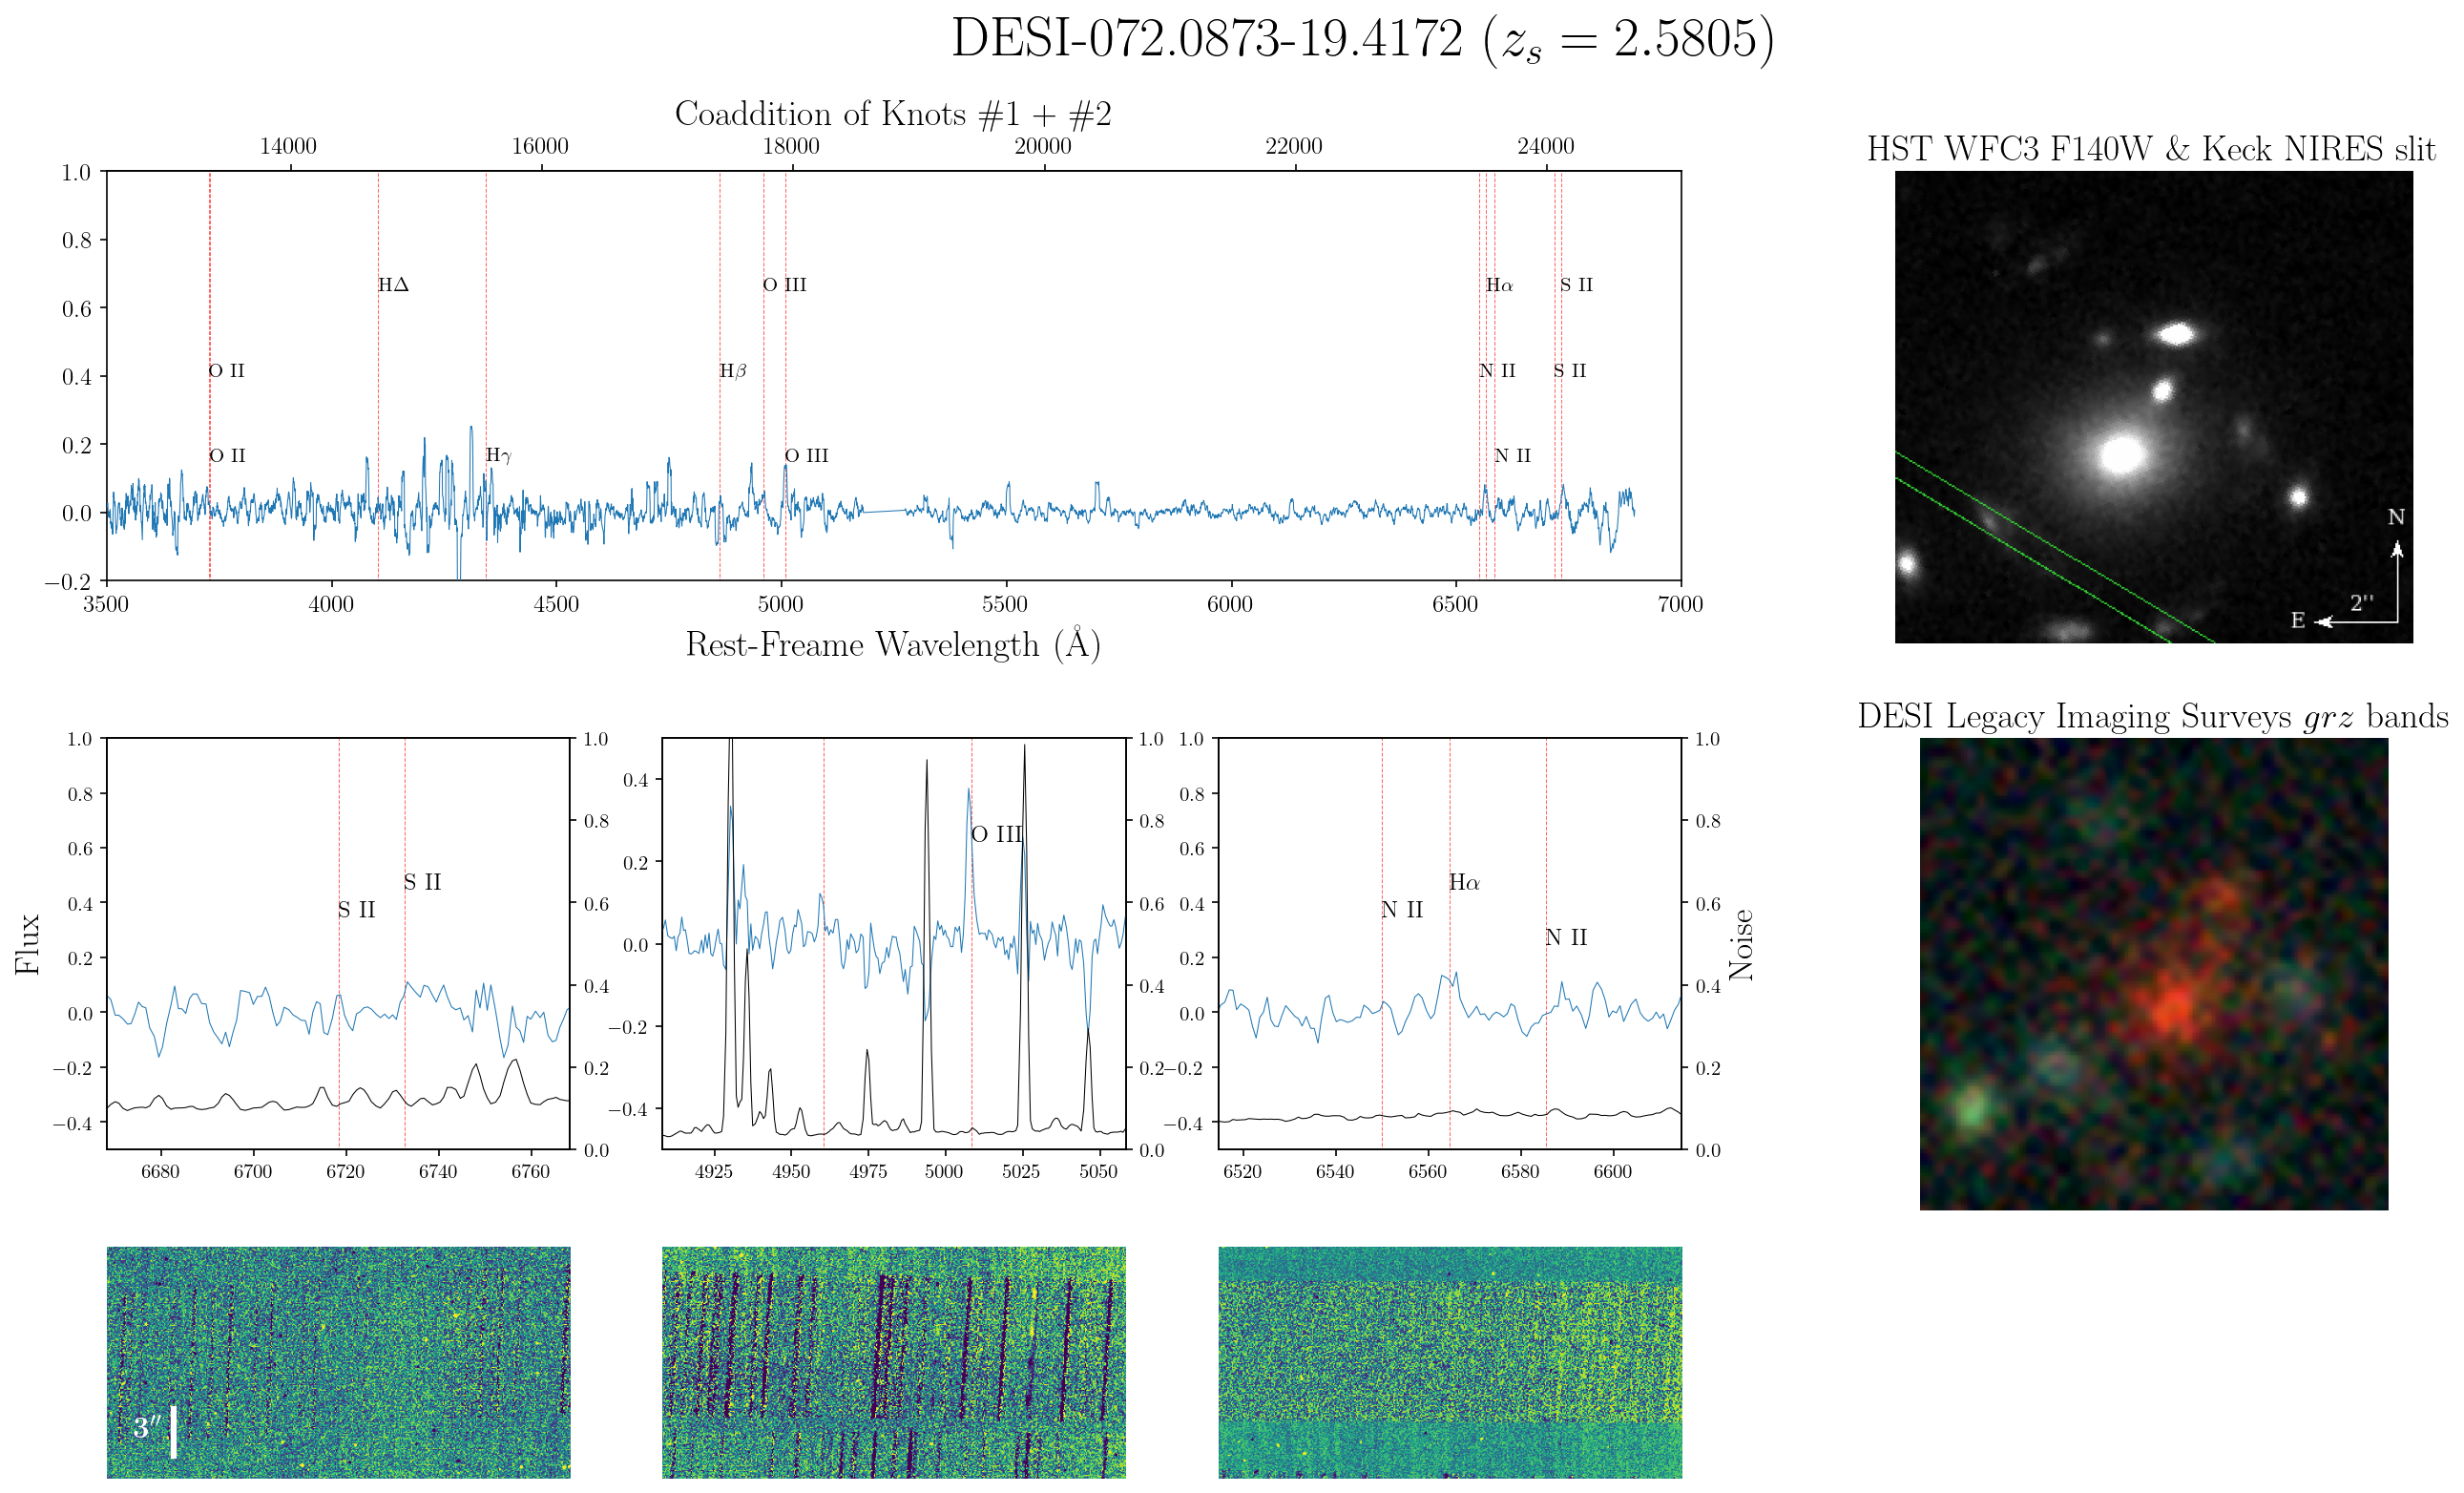

In [61]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(1,4, figure=fig, top=0.93, bottom=0.80, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-072.0873-19.4172 ($z_s = 2.5805$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])

f_ax1.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 1)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax1.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################
gs2 = fig.add_gridspec(17,17, top=0.75,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],0.25+(0.1*(i%3))),text=row['SPECIES'], size=12)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[10]-50,redshifted.values[10]+50)
f_ax6.set_ylim(-0.5, 1)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.25+(0.2*(i%3))),text=row['SPECIES'], size=12)
f_ax4.set_xlim(redshifted.values[6]-100,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.25+(0.1*(i%3))),text=row['SPECIES'], size=12)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 1)

######################################################

f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi072_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1450, color='white', linewidth=3)
f_ax9.text(1450+35,320, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
f_ax9.set_xlim(1308-200, 1308+200)
f_ax9.set_ylim(389.-100, 389.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi072_spec2d), vmin=-3, vmax=3)
f_ax8.invert_yaxis()
# f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1240, color='white', linewidth=3)
f_ax8.set_xlim(292-80, 292+320)
f_ax8.set_ylim(700-100, 700+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi072_spec2d), vmin=-5, vmax=5)
f_ax9.invert_yaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(418-200, 418+200)
f_ax9.set_ylim(871-100, 871+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')
# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.60, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi072_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi072_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desii072_plot.png')
plt.show()

In [55]:
gal_em#['vac (Å)'][3] * (1+z)

vac (Å)  Galaxy Quasar    SPECIES
0   2799.117     1.0    8.0      Mg II
1   3727.092     5.0    1.0       O II
2   4102.890     0.5    2.0  H$\Delta$
3   4341.680     1.0    3.0  H$\gamma$
4   4862.680     2.0    4.0   H$\beta$
5   4960.295     2.0    2.0      O III
6   5008.240     3.0    2.0      O III
7   6549.860     3.0    0.0       N II
8   6564.610     8.0    8.0  H$\alpha$
9   6585.270     3.0    0.0       N II
10  6718.290     3.0    0.0       S II
11  6732.670     3.0    0.0       S II
12  3729.000     1.0      0       O II

## DESI-215

In [13]:
desi215_1 = sorted(glob('2023-01-11/DESI215/reducing_folder/keck_nires_B/*DESI*'))
desi215_2 = sorted(glob('2024-04-27/DESI-215/reducing_folder/keck_nires_A/*DESI*'))
desi215_c = sorted(glob('215_coadd/*DESI*'))

desi_215_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_215_cutout.png'
desi_215_img_path = '/home/tamar/findinglens/keck/plot_images/desi_215_img.png'

desi215_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi215_2dspec_coadd.fits'



desi215_1, desi215_2, desi215_c

(['2023-01-11/DESI215/reducing_folder/keck_nires_B/DESI-215_coadd.fits',
  '2023-01-11/DESI215/reducing_folder/keck_nires_B/DESI-215_coadd_1.fits',
  '2023-01-11/DESI215/reducing_folder/keck_nires_B/DESI-215_coadd_2.fits'],
 ['2024-04-27/DESI-215/reducing_folder/keck_nires_A/DESI-215_1_coadd.fits',
  '2024-04-27/DESI-215/reducing_folder/keck_nires_A/DESI-215_2_coadd.fits',
  '2024-04-27/DESI-215/reducing_folder/keck_nires_A/DESI-215_coadd.fits'],
 ['215_coadd/DESI-215_coadd.fits'])

In [14]:
desi215_hst_img = np.asarray(Image.open(desi_215_img_path))
desi215_legacy_cutout = np.asarray(Image.open(desi_215_dr9_path))

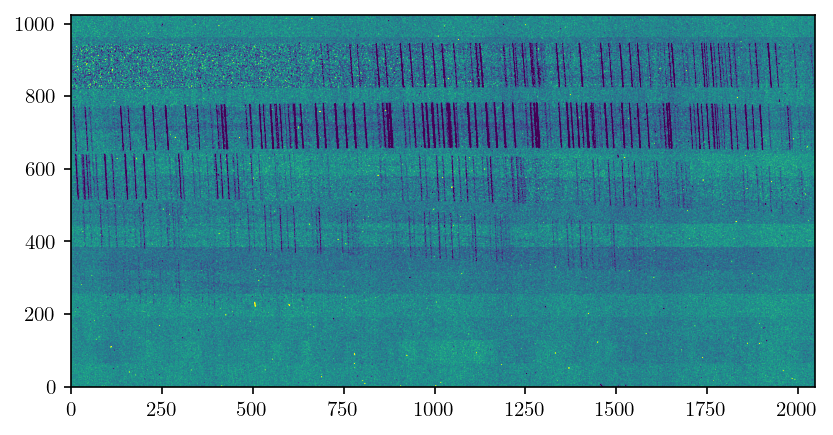

In [15]:
%matplotlib inline
spec2d = fits.getdata(desi215_spec2d_p)
plt.figure(dpi=150)
plt.imshow(np.arcsinh(spec2d), vmin=-15/5, vmax=15/5)
plt.gca().invert_yaxis()
# plt.axvline(ymin=0.2,ymax=0.5, x=850, color='red')

[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!
[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!
[WARNING] :: Wavelengths are not monotonically increasing!  Strict was set to False, so measurements after a negative step in wavelength are removed from the constructed spectrum.  BEWARE that this is likely the result of an error in the data reduction!


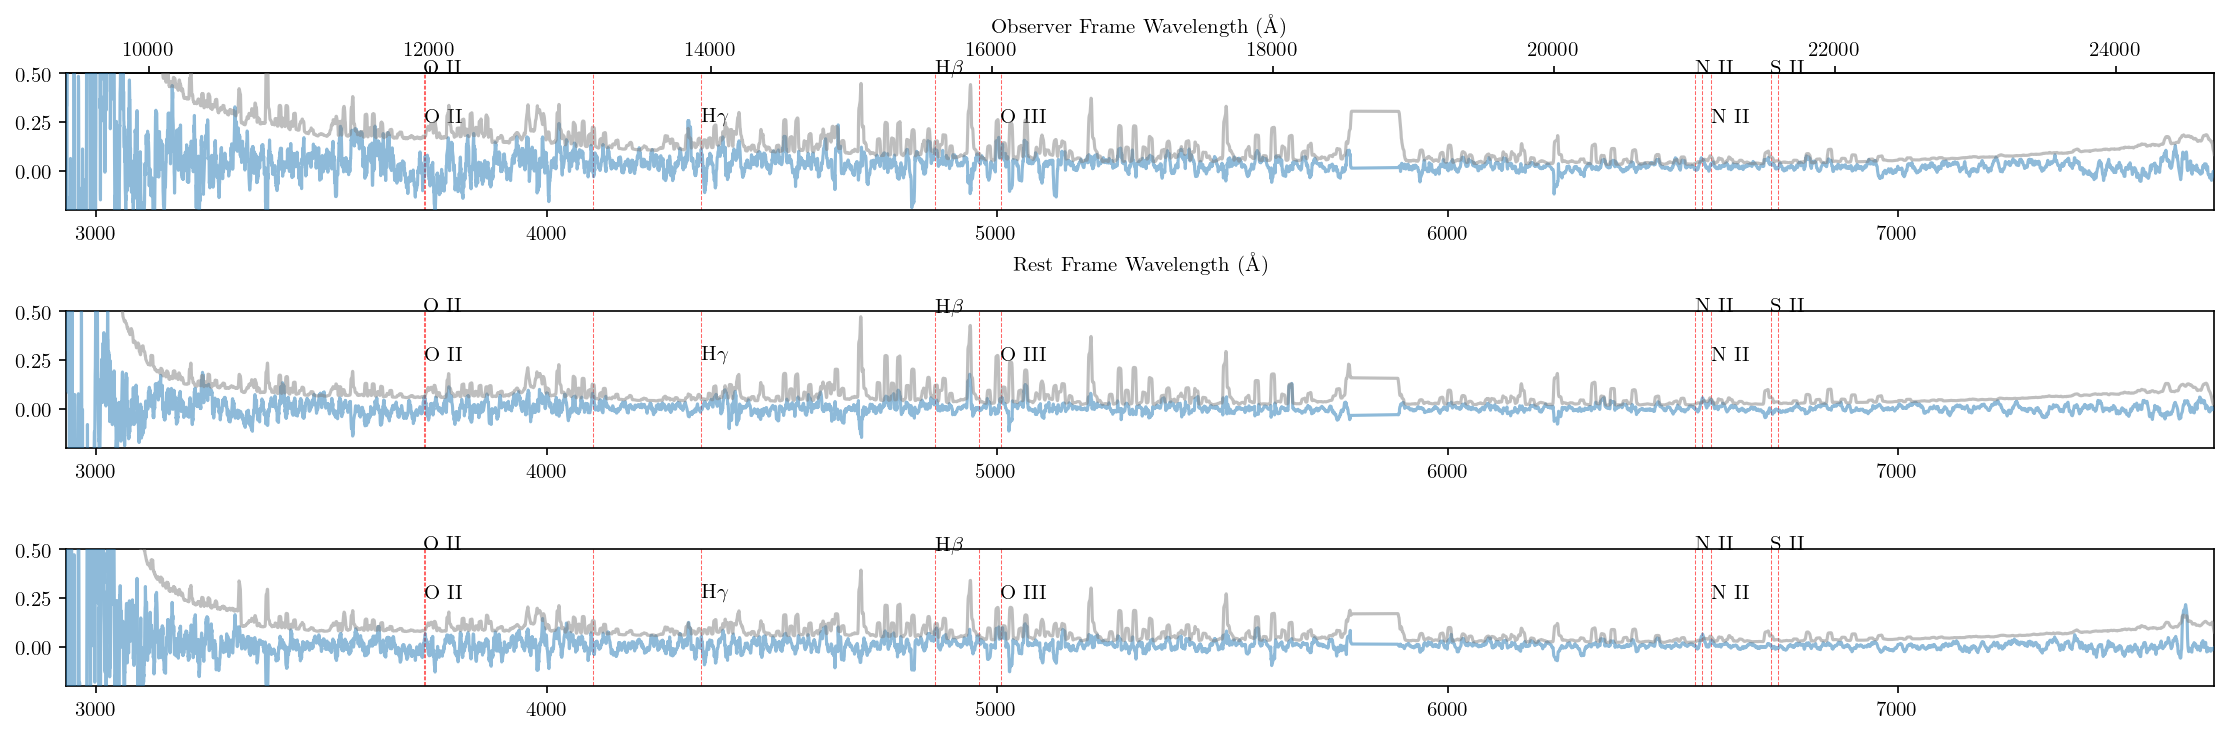

In [16]:
coad_spec = Spectrum1D.read(desi215_c[0], strict=False)
coad_spec1 = Spectrum1D.read(desi215_1[0], strict = False)
coad_spec2 = Spectrum1D.read(desi215_2[2], strict = False)


smth = bigsmth
z = 2.2075

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

wv = wave.airtovac(coad_spec1.spectral_axis)
fx = coad_spec1.flux
err = coad_spec1.uncertainty

fwv_c1 = wv[wv>0]
ffx_c1 = fx[wv>0]
ferr_c1 = err[wv>0].array

wv = wave.airtovac(coad_spec2.spectral_axis)
fx = coad_spec2.flux
err = coad_spec2.uncertainty

fwv_c2 = wv[wv>0]
ffx_c2 = fx[wv>0]
ferr_c2 = err[wv>0].array

fig, ax = plt.subplots(3,1, figsize=(15,5), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

sfx_c1 = np.convolve(ffx_c1, np.ones(smth)/smth, 'same')
sferr_c1 = np.convolve(ferr_c1, np.ones(smth)/smth, 'same')

sfx_c2 = np.convolve(ffx_c2, np.ones(smth)/smth, 'same')
sferr_c2 = np.convolve(ferr_c2, np.ones(smth)/smth, 'same')



ax[0].plot(fwv_c1/(1+z),sfx_c1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[0].plot(fwv_c1/(1+z),sferr_c1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax[0].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax[0].set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')

ax[1].plot(fwv_c2/(1+z),sfx_c2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[1].plot(fwv_c2/(1+z),sferr_c2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')

ax[2].plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[2].plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')





for axs in ax:
    for i,row in gal_em.iterrows():
        axs.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
        axs.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

    axs.set_ylim(-0.2, 0.5)
    axs.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))



fig.tight_layout()
plt.show()

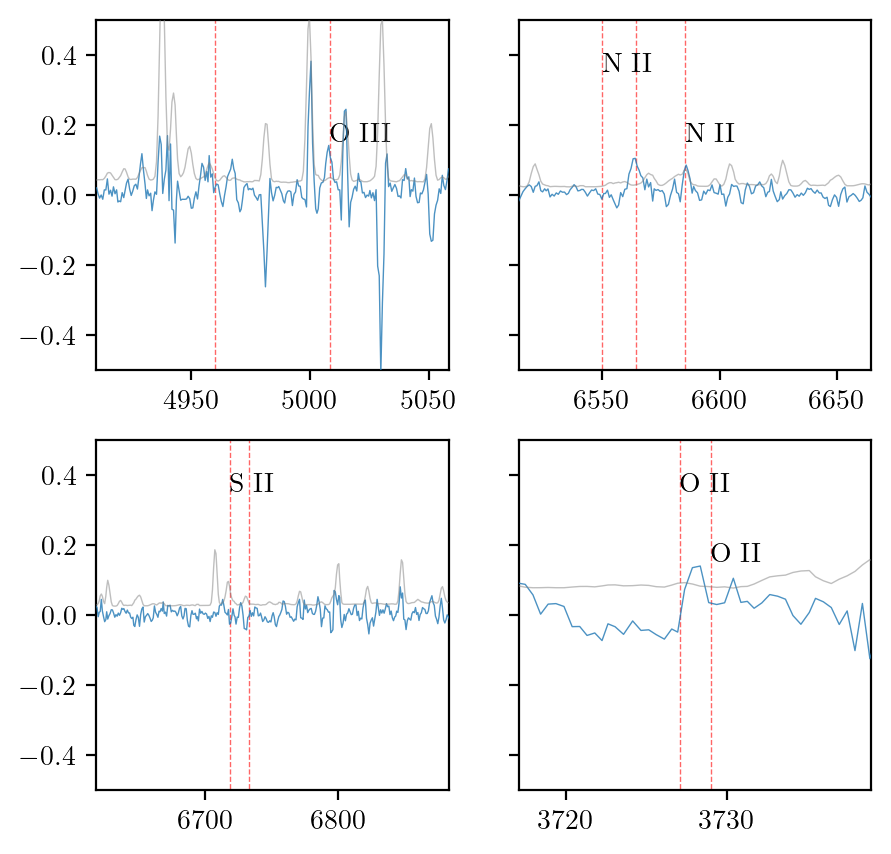

In [17]:
fig, ax = plt.subplots(2,2, figsize=(5,5), sharey=True, dpi=200)

redshifted = gal_em[['vac (Å)']] 

%matplotlib inline

smth = smallsmth


sfwv_c = fwv_c

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-50,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 0.5)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 0.5)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 0.5)

ax[1][1].set_xlim(redshifted.values[1]-10,redshifted.values[12]+10)
ax[1][1].set_ylim(-0.5, 0.5)




plt.show()

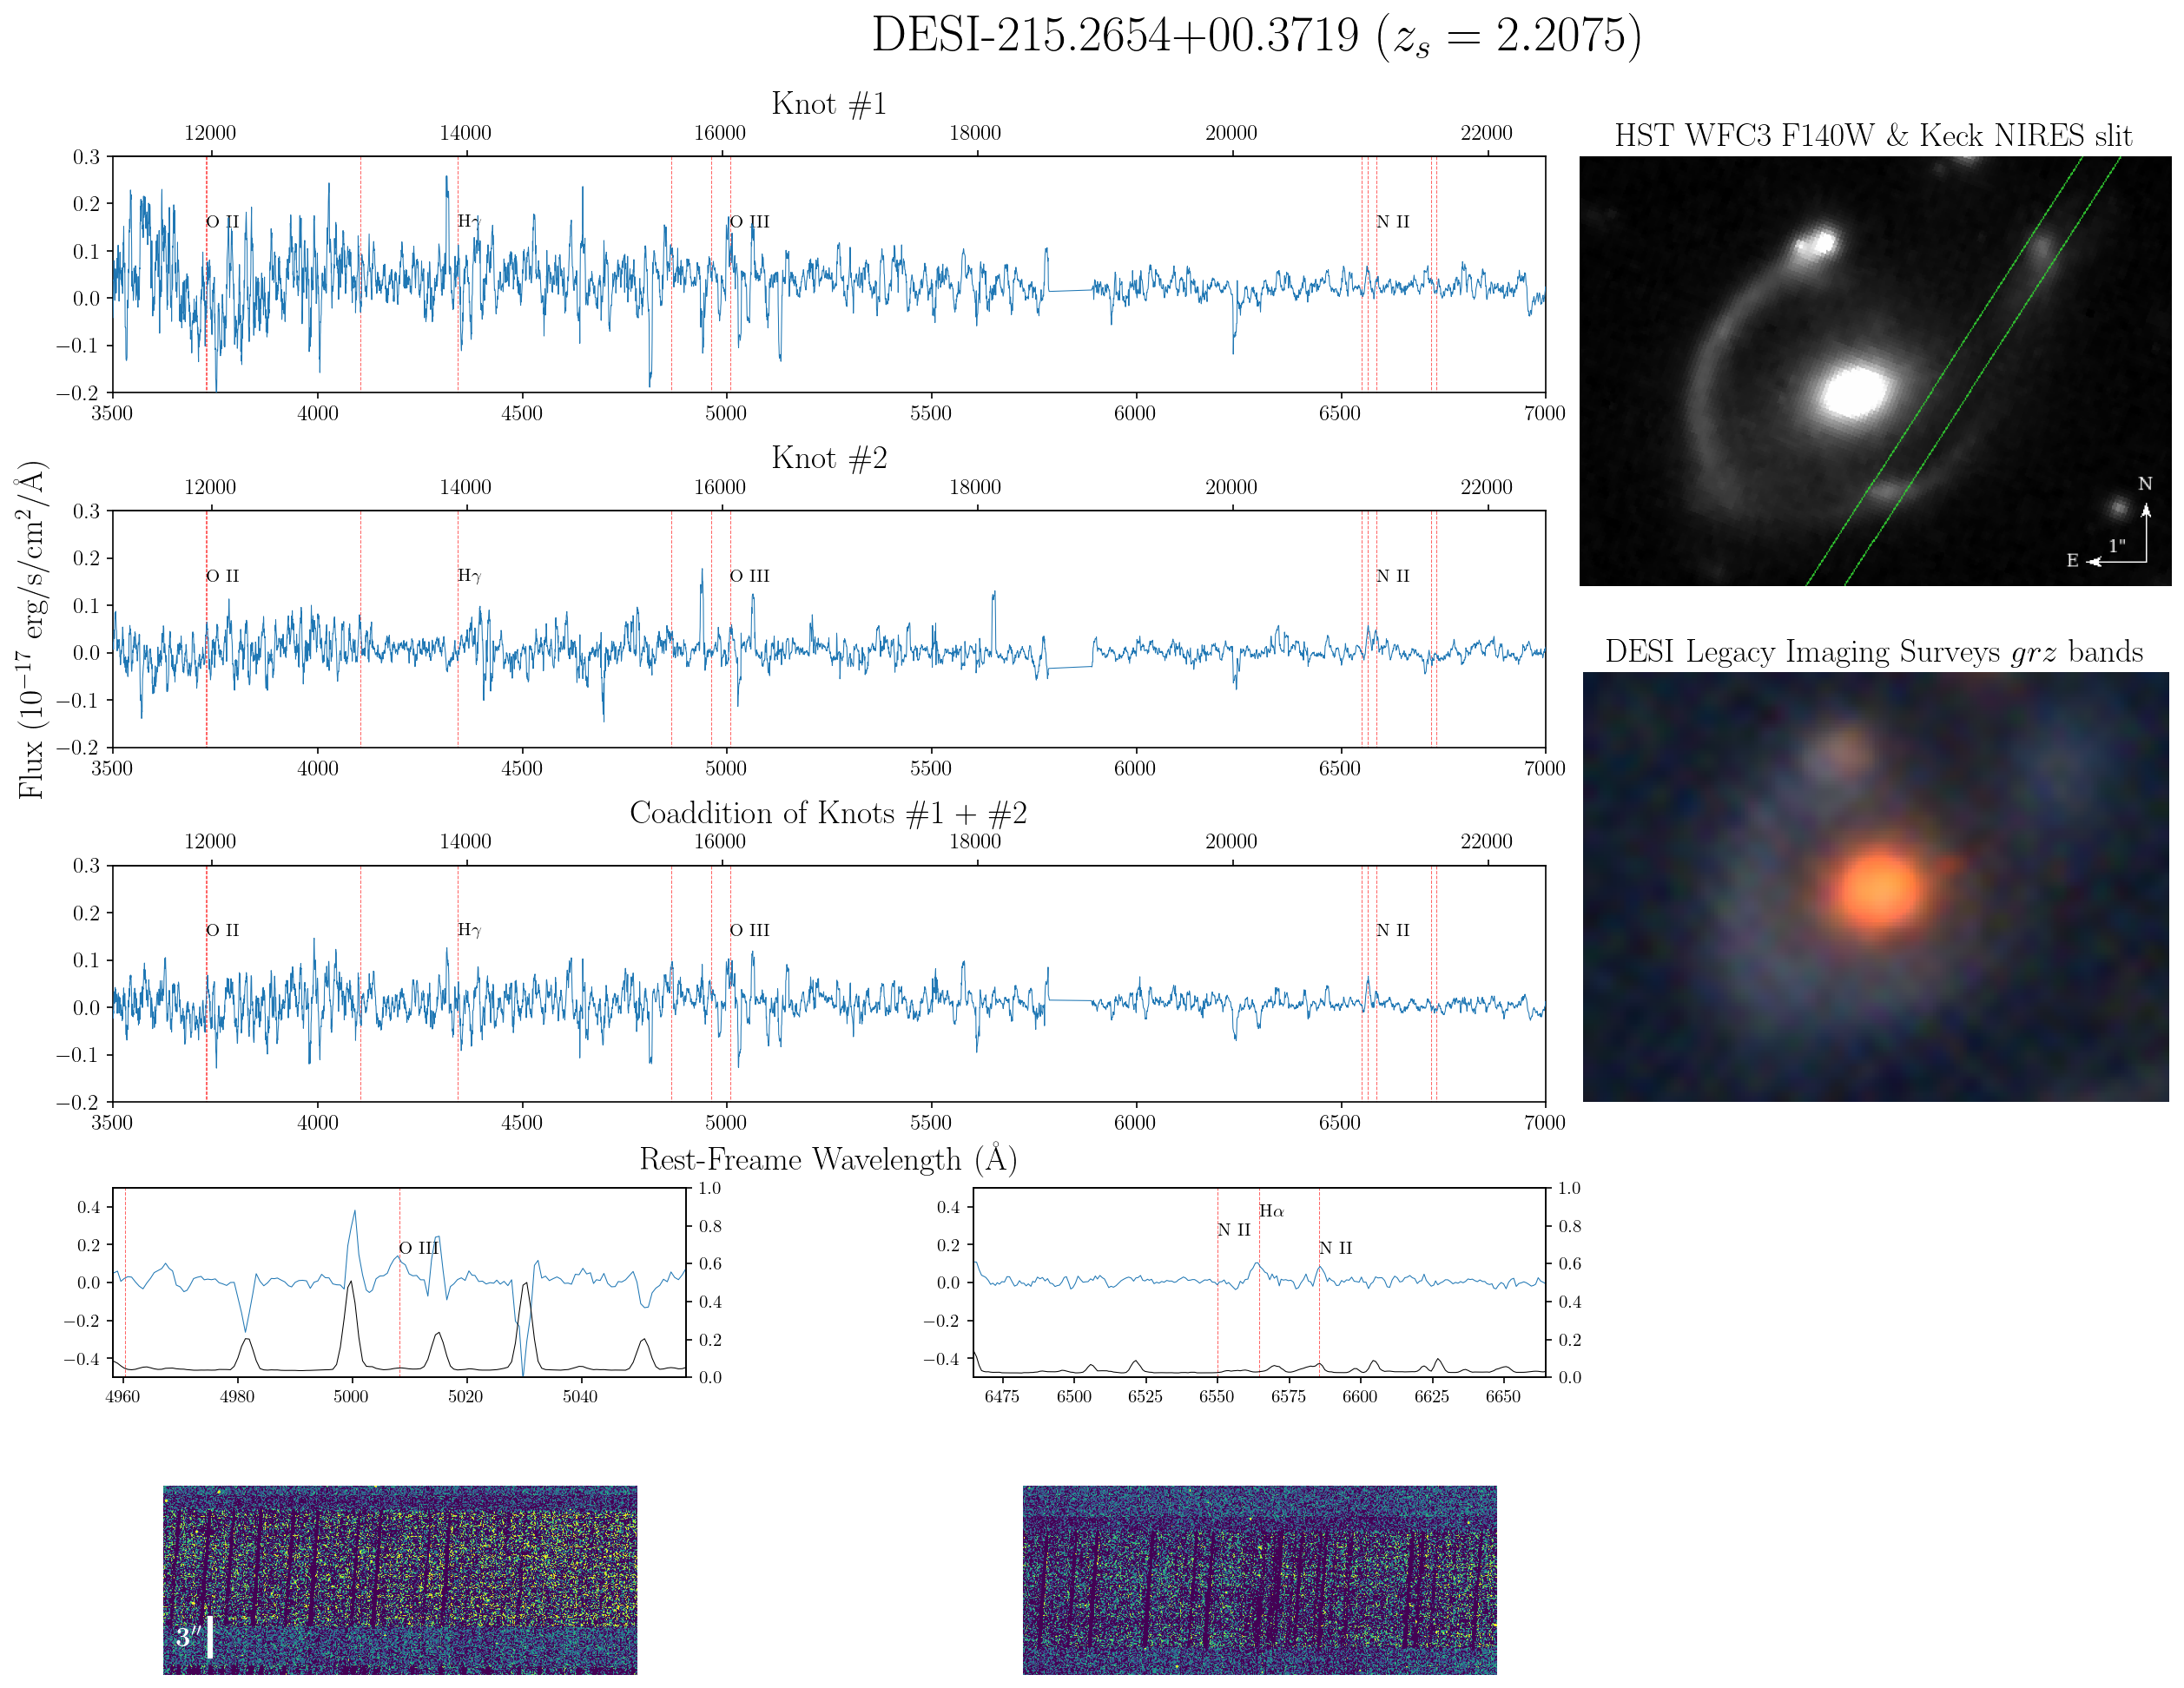

In [18]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(3,4, figure=fig, top=0.93, bottom=0.60, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-215.2654+00.3719 ($z_s = 2.2075$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])


f_ax1.plot(fwv_c1/(1+z),sfx_c1, linewidth=.5, zorder=20, color='tab:blue')
# f_ax1.plot(fwv_c1/(1+z),sferr_c1, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 0.3)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Knot \#1', size=18)

f_ax2 = fig.add_subplot(gs[1, :4])

f_ax2.plot(fwv_c2/(1+z),sfx_c2, linewidth=.5, zorder=20, color='tab:blue')
# f_ax2.plot(fwv_c2/(1+z),sferr_c2, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax2.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax2.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax2.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax2.set_ylim(-0.2, 0.3)
f_ax2.set_xlim(3500,7000)
f_ax2.tick_params(axis='x', labelsize=12)
f_ax2.tick_params(axis='y', labelsize=12)
f_ax2.set_title('Knot \#2', size=18)
f_ax2.set_ylabel(r'Flux ($10^{-17}$ erg/s/cm$^{2}$/\AA)', size=18)

f_ax3 = fig.add_subplot(gs[2, :4])

f_ax3.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax3.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax3.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax3.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax3.set_ylim(-0.2, 0.3)
f_ax3.set_xlim(3500,7000)
f_ax3.tick_params(axis='x', labelsize=12)
f_ax3.tick_params(axis='y', labelsize=12)
f_ax3.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax3.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################

gs2 = fig.add_gridspec(5,5, top=0.57,  bottom=0.40, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

# gs20 = gs2[:4,0].subgridspec(2,1)


f_ax4 = fig.add_subplot(gs2[0:2,0:2])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])
f_ax4.set_xlim(redshifted.values[6]-50,redshifted.values[6]+50)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:2,3:5])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'])
f_ax5.set_xlim(redshifted.values[8]-100,redshifted.values[8]+100)
f_ax5.set_ylim(-0.5, 0.5)

######################################################

f_ax8 = fig.add_subplot(gs2[3:5,0:2])
f_ax8.imshow(np.arcsinh(spec2d), vmin=-1, vmax=3)
f_ax8.invert_yaxis()
f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1020, color='white', linewidth=3)
f_ax8.text(1020+35,795, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
f_ax8.set_xlim(819.53-250, 819.53+250)
f_ax8.set_ylim(870.39-100, 870.39+100)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[3:5, 3:5])
f_ax9.imshow(np.arcsinh(spec2d), vmin=-1, vmax=3)
f_ax9.invert_yaxis()
f_ax9.set_xlim(1286.19-250, 1286.19+250)
f_ax9.set_ylim(893.42-100, 893.42+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')
# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.53, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi215_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi215_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desi_215_plot.png')
plt.show()

## DESI-225

In [ ]:
desi225 = glob('2024-03-26/DESI225/reducing_folder/keck_nires_A/*DESI*')

desi_225_img_path = '/home/tamar/findinglens/keck/plot_images/desi_225_img.png'

desi_225_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_225_cutout.png'

desi225_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi225_2dspec_coadd.fits'


desi225_hst_img = np.asarray(Image.open(desi_225_img_path))
desi225_legacy_cutout = np.asarray(Image.open(desi_225_dr9_path))
desi225_spec2d = fits.getdata(desi225_spec2d_p)

desi225

In [ ]:
spec1 = Spectrum1D.read(desi225[2], strict=False)
spec2 = Spectrum1D.read(desi225[3], strict=False)
coad_spec = Spectrum1D.read(desi225[4], strict=False)


smth = bigsmth
z = 2.4176

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

wv = wave.airtovac(spec1.spectral_axis)
fx = spec1.flux
err = spec1.uncertainty

fwv_1 = wv[wv>0]
ffx_1 = fx[wv>0]
ferr_1 = err[wv>0].array

wv = wave.airtovac(spec2.spectral_axis)
fx = spec2.flux
err = spec2.uncertainty

fwv_2 = wv[wv>0]
ffx_2 = fx[wv>0]
ferr_2 = err[wv>0].array



fig, ax = plt.subplots(3,1, figsize=(12,8), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

sfx_1 = np.convolve(ffx_1, np.ones(smth)/smth, 'same')
sferr_1 = np.convolve(ferr_1, np.ones(smth)/smth, 'same')

sfx_2 = np.convolve(ffx_2, np.ones(smth)/smth, 'same')
sferr_2 = np.convolve(ferr_2, np.ones(smth)/smth, 'same')


ax[0].plot(fwv_1/(1+z),sfx_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[0].plot(fwv_1/(1+z),sferr_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax[0].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax[0].set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')

ax[1].plot(fwv_2/(1+z),sfx_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[1].plot(fwv_2/(1+z),sferr_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[1].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))

ax[2].plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[2].plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[2].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))




for axs in ax:
    for i,row in gal_em.iterrows():
        axs.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
        axs.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

    axs.set_ylim(-0.2, 0.6)
    axs.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))



fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), sharey=True, dpi=200)

redshifted = gal_em[['vac (Å)']] #* (2.2+1)

%matplotlib inline

smth = smallsmth

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-200,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 1)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 1)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 1)

ax[1][1].set_xlim(redshifted.values[1]-50,redshifted.values[12]+50)
ax[1][1].set_ylim(-0.5, 1)




plt.show()

In [ ]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(3,4, figure=fig, top=0.93, bottom=0.60, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-225.4050+52.1417 ($z_s = 2.4176$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])


f_ax1.plot(fwv_1/(1+z),sfx_1, linewidth=.5, zorder=20, color='tab:blue')
# f_ax1.plot(fwv_c1/(1+z),sferr_c1, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 0.4)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Knot \#1', size=18)

f_ax2 = fig.add_subplot(gs[1, :4])

f_ax2.plot(fwv_2/(1+z),sfx_2, linewidth=.5, zorder=20, color='tab:blue')
# f_ax2.plot(fwv_c2/(1+z),sferr_c2, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax2.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax2.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax2.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax2.set_ylim(-0.2, 0.4)
f_ax2.set_xlim(3500,7000)
f_ax2.tick_params(axis='x', labelsize=12)
f_ax2.tick_params(axis='y', labelsize=12)
f_ax2.set_title('Knot \#2', size=18)
f_ax2.set_ylabel(r'Flux ($10^{-17}$ erg/s/cm$^{2}$/\AA)', size=18)

f_ax3 = fig.add_subplot(gs[2, :4])

f_ax3.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax3.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax3.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax3.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax3.set_ylim(-0.2, 0.4)
f_ax3.set_xlim(3500,7000)
f_ax3.tick_params(axis='x', labelsize=12)
f_ax3.tick_params(axis='y', labelsize=12)
f_ax3.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax3.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################

gs2 = fig.add_gridspec(17,17, top=0.57,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

# gs20 = gs2[:4,0].subgridspec(2,1)

f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 0.5)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'], size=5)
f_ax4.set_xlim(redshifted.values[6]-200,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 0.5)

######################################################
f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi225_spec2d), vmin=-2, vmax=5)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=730, color='white', linewidth=3)
f_ax9.text(730+35,820, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(532.511-250, 532.511+250)
f_ax9.set_ylim(900-100, 900+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi225_spec2d), vmin=-1, vmax=3)
f_ax8.invert_yaxis()
f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1240, color='white', linewidth=3)
f_ax8.set_xlim(680-100, 680+400)
f_ax8.set_ylim(720-100, 720+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi225_spec2d), vmin=-1, vmax=4)
f_ax9.invert_yaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(800-250, 800+250)
f_ax9.set_ylim(885.-100, 885.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.52, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi225_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi225_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desi_225_plot.png')
plt.show()

In [ ]:
gal_em['vac (Å)'][12] * (1+z)

## DESI-234

In [ ]:
desi234 = glob('2024-03-26/DESI234/reducing_folder/keck_nires_A/*DESI*')

desi_234_img_path = '/home/tamar/findinglens/keck/plot_images/desi_234_img.png'
desi_234_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_234_cutout.png'
desi234_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi234_2dspec_coadd.fits'


desi234_hst_img = np.asarray(Image.open(desi_234_img_path))
desi234_legacy_cutout = np.asarray(Image.open(desi_234_dr9_path))
desi234_spec2d = fits.getdata(desi234_spec2d_p)

desi234

In [ ]:
coad_spec = Spectrum1D.read(desi234[0], strict=False)


smth = bigsmth
z = 2.478

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array



fig, ax = plt.subplots(1,1, figsize=(15,5), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')



ax.plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax.plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax.set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')







for i,row in gal_em.iterrows():
    ax.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

ax.set_ylim(-0.2, 2)
ax.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))



fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), sharey=True, dpi=200)

redshifted = gal_em[['vac (Å)']] #* (2.2+1)

%matplotlib inline

smth = smallsmth

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-200,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 2)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 2)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 2)

ax[1][1].set_xlim(redshifted.values[1]-50,redshifted.values[12]+50)
ax[1][1].set_ylim(-0.5, 2)




plt.show()

In [ ]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(1,4, figure=fig, top=0.93, bottom=0.80, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI--234.4783+14.7232 ($z_s = 2.4780$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])

f_ax1.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 2)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax1.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################
gs2 = fig.add_gridspec(17,17, top=0.75,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 2)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'], size=5)
f_ax4.set_xlim(redshifted.values[6]-200,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 2)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 2)

######################################################

f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi234_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1280, color='white', linewidth=3)
f_ax9.text(1280+35,510, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
f_ax9.set_xlim(1120-200, 1120+200)
f_ax9.set_ylim(580.-100, 580.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi234_spec2d), vmin=-1, vmax=3)
f_ax8.invert_yaxis()
# f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1240, color='white', linewidth=3)
f_ax8.set_xlim(670-200, 670+200)
f_ax8.set_ylim(720-100, 720+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi234_spec2d), vmin=-1, vmax=4)
f_ax9.invert_yaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(662-200, 662+200)
f_ax9.set_ylim(880-100, 880+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')
# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.55, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi234_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi234_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desi_234_plot.png')
plt.show()

## DESI-238

In [ ]:
desi238 = glob('2024-03-26/DESI238/reducing_folder/keck_nires_A/*DESI*')
desi238_2 = sorted(glob('2024-04-27/DESI-238_2/reducing_folder/keck_nires_A/*DESI*'))
desi238_c = glob('238_coadd/*DESI*')

desi_238_1_img_path = '/home/tamar/findinglens/keck/plot_images/desi_238_1_img.png'
desi_238_2_img_path = '/home/tamar/findinglens/keck/plot_images/desi_238_2_img.png'
desi_238_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_238_cutout.png'
desi238_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi238_2dspec_coadd.fits'


desi238_hst_img_1 = np.asarray(Image.open(desi_238_1_img_path))
desi238_hst_img_2 = np.asarray(Image.open(desi_238_2_img_path))
desi238_legacy_cutout = np.asarray(Image.open(desi_238_dr9_path))
desi238_spec2d = fits.getdata(desi238_spec2d_p)

desi238, desi238_2, desi238_c

In [ ]:
coad_spec = Spectrum1D.read(desi238_c[0], strict=False)
coad_spec1 = Spectrum1D.read(desi238[0], strict = False)
coad_spec2 = Spectrum1D.read(desi238_2[5], strict = False)


smth = bigsmth
z = 1.721

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

wv = wave.airtovac(coad_spec1.spectral_axis)
fx = coad_spec1.flux
err = coad_spec1.uncertainty

fwv_c1 = wv[wv>0]
ffx_c1 = fx[wv>0]
ferr_c1 = err[wv>0].array

wv = wave.airtovac(coad_spec2.spectral_axis)
fx = coad_spec2.flux
err = coad_spec2.uncertainty

fwv_c2 = wv[wv>0]
ffx_c2 = fx[wv>0]
ferr_c2 = err[wv>0].array

fig, ax = plt.subplots(3,1, figsize=(15,5), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

sfx_c1 = np.convolve(ffx_c1, np.ones(smth)/smth, 'same')
sferr_c1 = np.convolve(ferr_c1, np.ones(smth)/smth, 'same')

sfx_c2 = np.convolve(ffx_c2, np.ones(smth)/smth, 'same')
sferr_c2 = np.convolve(ferr_c2, np.ones(smth)/smth, 'same')



ax[0].plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[0].plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax[0].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax[0].set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')

ax[1].plot(fwv_c1/(1+z),sfx_c1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[1].plot(fwv_c1/(1+z),sferr_c1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')

ax[2].plot(fwv_c2/(1+z),sfx_c2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[2].plot(fwv_c2/(1+z),sferr_c2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')





for axs in ax:
    for i,row in gal_em.iterrows():
        axs.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
        axs.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

    axs.set_ylim(-0.2, 1)
    axs.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))



fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), dpi=200)

redshifted = gal_em[['vac (Å)']] 

%matplotlib inline

z=1.721

smth = smallsmth

fwv_c = fwv_c

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-200,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 1)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 1)
                
ax[1][0].set_xlim(redshifted.values[3]-100,redshifted.values[3]+150)
ax[1][0].set_ylim(-0.2, 0.2)

ax[1][1].set_xlim(redshifted.values[1]-50,redshifted.values[12]+50)
ax[1][1].set_ylim(-0.5, 1)




plt.show()

In [ ]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(3,4, figure=fig, top=0.93, bottom=0.60, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-238.5690+04.7276 ($z_s=1.7210$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])


f_ax1.plot(fwv_c1/(1+z),sfx_c1, linewidth=.5, zorder=20, color='tab:blue')
# f_ax1.plot(fwv_c1/(1+z),sferr_c1, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 0.4)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Knot \#1', size=18)

f_ax2 = fig.add_subplot(gs[1, :4])

f_ax2.plot(fwv_c2/(1+z),sfx_c2, linewidth=.5, zorder=20, color='tab:blue')
# f_ax2.plot(fwv_c2/(1+z),sferr_c2, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax2.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax2.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax2.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax2.set_ylim(-0.2, 0.4)
f_ax2.set_xlim(3500,7000)
f_ax2.tick_params(axis='x', labelsize=12)
f_ax2.tick_params(axis='y', labelsize=12)
f_ax2.set_title('Knot \#2', size=18)
f_ax2.set_ylabel(r'Flux ($10^{-17}$ erg/s/cm$^{2}$/\AA)', size=18)

f_ax3 = fig.add_subplot(gs[2, :4])

f_ax3.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax3.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax3.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax3.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax3.set_ylim(-0.2, 0.4)
f_ax3.set_xlim(3500,7000)
f_ax3.tick_params(axis='x', labelsize=12)
f_ax3.tick_params(axis='y', labelsize=12)
f_ax3.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax3.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################
gs2 = fig.add_gridspec(17,17, top=0.57,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)


f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 0.5)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'], size=5)
f_ax4.set_xlim(redshifted.values[6]-200,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=5)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 0.5)

######################################################

f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi238_spec2d), vmin=-2, vmax=2)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1800, color='white', linewidth=3)
f_ax9.text(1800+35,300, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(1594-250, 1594+250)
f_ax9.set_ylim(378-100, 378+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi238_spec2d), vmin=-1, vmax=3)
f_ax8.invert_yaxis()
f_ax8.set_ylim(485-100, 485+100)
f_ax8.set_xlim(1187-80,1187+400)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi238_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.invert_xaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(320-250, 320+250)
f_ax9.set_ylim(710.-100,710.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')


# ###############################################################################################################################

gs3 = fig.add_gridspec(3,1, left=0.55, right=0.90, top=0.93,bottom=0.45)

f_ax6 = fig.add_subplot(gs3[0])
f_ax6.imshow(desi238_hst_img_1)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)

f_ax6 = fig.add_subplot(gs3[1])
f_ax6.imshow(desi238_hst_img_2)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[2])
f_ax7.imshow(desi238_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desi_238_plot.png')
plt.show()

In [ ]:
desi238_spec2d.shape

In [ ]:
gal_em['vac (Å)'][5]*(1+1.721)

## DESI-246

In [ ]:
desi246 = sorted(glob('2024-04-27/DESI-246_01/reducing_folder/keck_nires_A/*DESI*'))

desi_246_img_path = '/home/tamar/findinglens/keck/plot_images/desi_246_img.png'
desi_246_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_246_cutout.png'
desi246_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi246_2dspec_coadd.fits'


desi246_hst_img = np.asarray(Image.open(desi_246_img_path))
desi246_legacy_cutout = np.asarray(Image.open(desi_246_dr9_path))
desi246_spec2d = fits.getdata(desi246_spec2d_p)

desi246

In [ ]:
spec1 = Spectrum1D.read(desi246[0], strict=False)
spec2 = Spectrum1D.read(desi246[1], strict=False)
coad_spec = Spectrum1D.read(desi246[3], strict=False)
mid_spec = Spectrum1D.read(desi246[2], strict=False)


smth = bigsmth
z = 2.3685
z_2=2.3668

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

wv = wave.airtovac(spec1.spectral_axis)
fx = spec1.flux
err = spec1.uncertainty

fwv_1 = wv[wv>0]
ffx_1 = fx[wv>0]
ferr_1 = err[wv>0].array

wv = wave.airtovac(spec2.spectral_axis)
fx = spec2.flux
err = spec2.uncertainty

fwv_2 = wv[wv>0]
ffx_2 = fx[wv>0]
ferr_2 = err[wv>0].array

wv = wave.airtovac(mid_spec.spectral_axis)
fx = mid_spec.flux
err = mid_spec.uncertainty

fwv_mid = wv[wv>0]
ffx_mid = fx[wv>0]
ferr_mid = err[wv>0].array


fig, ax = plt.subplots(4,1, figsize=(12,8), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

sfx_1 = np.convolve(ffx_1, np.ones(smth)/smth, 'same')
sferr_1 = np.convolve(ferr_1, np.ones(smth)/smth, 'same')

sfx_2 = np.convolve(ffx_2, np.ones(smth)/smth, 'same')
sferr_2 = np.convolve(ferr_2, np.ones(smth)/smth, 'same')

sfx_mid = np.convolve(ffx_mid, np.ones(smth)/smth, 'same')
sferr_mid = np.convolve(ferr_mid, np.ones(smth)/smth, 'same')

ax[0].plot(fwv_1/(1+z),sfx_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[0].plot(fwv_1/(1+z),sferr_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax[0].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax[0].set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')

ax[1].plot(fwv_2/(1+z),sfx_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[1].plot(fwv_2/(1+z),sferr_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[1].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))

ax[2].plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[2].plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[2].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))


for axs in ax[:3]:
    for i,row in gal_em.iterrows():
        axs.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
        axs.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

    axs.set_ylim(-0.2, 0.6)
    axs.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))

ax[3].set_title('Middle Trace')
ax[3].plot(fwv_mid/(1+z_2),sfx_mid, linewidth=1.5, zorder=20, alpha=0.5, color='tab:red')
ax[3].plot(fwv_mid/(1+z_2),sferr_mid, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[3].secondary_xaxis('top', functions=(lambda x: x*(1+z_2), lambda x: x/(1+z_2)))

for i,row in gal_em.iterrows():
    ax[3].plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    ax[3].annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

ax[3].set_ylim(-0.2, 0.6)
ax[3].set_xlim(fwv_c.min().value/(1+z_2),fwv_c.max().value/(1+z_2))

fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), dpi=200)

redshifted = gal_em[['vac (Å)']] #* (2.2+1)

%matplotlib inline

smth = smallsmth

fwv_c = fwv_c

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-50,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 0.5)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 0.5)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 0.5)

ax[1][1].set_xlim(redshifted.values[1]-10,redshifted.values[12]+10)
ax[1][1].set_ylim(-0.5, 0.5)




plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), sharey=True, dpi=200)

redshifted = gal_em[['vac (Å)']] #* (2.2+1)

%matplotlib inline

smth = smallsmth


ssfx_mid = np.convolve(ffx_mid, np.ones(smth)/smth, 'same')
ssferr_mid = np.convolve(ferr_mid, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_mid/(1+z_2),sfx_mid, linewidth=.5, zorder=20, alpha=0.8, color='tab:red')
ax[0][0].plot(fwv_mid/(1+z_2),sferr_mid, linewidth=.5, zorder=20, alpha=0.5, color='tab:orange')
ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[0][1].plot(fwv_mid/(1+z_2),sfx_mid, linewidth=.5, zorder=20, alpha=0.8, color='tab:red')
ax[0][1].plot(fwv_mid/(1+z_2),sferr_mid, linewidth=.5, zorder=20, alpha=0.5, color='tab:orange')
ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_mid/(1+z_2),sfx_mid, linewidth=.5, zorder=20, alpha=0.8, color='tab:red')
ax[1][0].plot(fwv_mid/(1+z_2),sferr_mid, linewidth=.5, zorder=20, alpha=0.5, color='tab:orange')
ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_mid/(1+z_2),sfx_mid, linewidth=.5, zorder=20, alpha=0.8, color='tab:red')
ax[1][1].plot(fwv_mid/(1+z_2),sferr_mid, linewidth=.5, zorder=20, alpha=0.5, color='tab:orange')
ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.10+(0.2*(i%3))),text=row['SPECIES'], fontsize=8)

    
ax[0][0].set_xlim(redshifted.values[5]-80,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 0.7)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 0.7)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 0.7)

ax[1][1].set_xlim(redshifted.values[1]-50,redshifted.values[12]+50)
ax[1][1].set_ylim(-0.5, 0.7)




plt.show()

In [ ]:
fig = plt.figure(dpi=150, figsize=(22,22))
gs = fig.add_gridspec(4,4, figure=fig, top=0.93, bottom=0.52, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-246.0062+01.4836 ($z_s1 = 2.3685, z_s2=2.3668$)', x=0.50, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])


f_ax1.plot(fwv_1/(1+z),sfx_1, linewidth=.5, zorder=20, color='tab:blue')
# f_ax1.plot(fwv_c1/(1+z),sferr_c1, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax1.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax1.set_ylim(-0.2, 0.3)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Knot \#1', size=18)

f_ax2 = fig.add_subplot(gs[1, :4])

f_ax2.plot(fwv_2/(1+z),sfx_2, linewidth=.5, zorder=20, color='tab:blue')
# f_ax2.plot(fwv_c2/(1+z),sferr_c2, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax2.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax2.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax2.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax2.set_ylim(-0.2, 0.3)
f_ax2.set_xlim(3500,7000)
f_ax2.tick_params(axis='x', labelsize=12)
f_ax2.tick_params(axis='y', labelsize=12)
f_ax2.set_title('Knot \#2', size=18)
f_ax2.set_ylabel(r'Flux ($10^{-17}$ erg/s/cm$^{2}$/\AA)', size=18)

f_ax3 = fig.add_subplot(gs[2, :4])

f_ax3.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax3.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax3.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax3.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax3.set_ylim(-0.2, 0.3)
f_ax3.set_xlim(3500,7000)
f_ax3.tick_params(axis='x', labelsize=12)
f_ax3.tick_params(axis='y', labelsize=12)
f_ax3.set_title('Coaddition of Knots \#1 + \#2', size=18)
# f_ax3.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)

f_ax12 = fig.add_subplot(gs[3, :4])
f_ax12.plot(fwv_mid/(1+z_2),sfx_mid, linewidth=.5, zorder=20, color='tab:red')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax12.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z_2)))
secax.tick_params(labelsize=12)
for i,row in gal_em.iterrows():
    f_ax12.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax12.annotate(xy=(row['vac (Å)'],0.15+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']), size=size)
f_ax12.set_ylim(-0.2, 0.3)
f_ax12.set_xlim(3500,7000)
f_ax12.tick_params(axis='x', labelsize=12)
f_ax12.tick_params(axis='y', labelsize=12)
f_ax12.set_title('Arc Center', size=18)
f_ax12.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################
gs2 = fig.add_gridspec(17,17, top=0.48,  bottom=0.20, left=0.1, right=0.6, wspace=0.001, hspace=0.1)


f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax6.plot(fwv_mid/(1+z_2),ssfx_mid, linewidth=.5, zorder=20, color='tab:red')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.plot(fwv_mid/(1+z_2),ssferr_mid, linewidth=.5, zorder=20, color='orange')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax6.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=8)
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 0.5)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax4.plot(fwv_mid/(1+z_2),ssfx_mid, linewidth=.5, zorder=20, color='tab:red')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.plot(fwv_mid/(1+z_2),ssferr_mid, linewidth=.5, zorder=20, color='orange')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'], size=8)
f_ax4.set_xlim(redshifted.values[6]-80,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax5.plot(fwv_mid/(1+z_2),ssfx_mid, linewidth=.5, zorder=20, color='tab:red')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.plot(fwv_mid/(1+z_2),ssferr_mid, linewidth=.5, zorder=20, color='orange')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=8)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 0.5)

######################################################

f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi246_spec2d), vmin=-2, vmax=3)
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1540+30, color='white', linewidth=3)
f_ax9.text(1575+30,480, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
f_ax9.invert_yaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(1365-250, 1365+250)
f_ax9.set_ylim(557-100, 557+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi246_spec2d), vmin=-1, vmax=3)
f_ax8.invert_yaxis()
f_ax8.set_xlim(785-180, 785+300)
f_ax8.set_ylim(719-100, 719+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi246_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.invert_xaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(905-250, 905+250)
f_ax9.set_ylim(900-100, 900+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.62, right=0.90, top=0.93,bottom=0.5)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi246_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi246_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('desi_246_plot.png')
plt.show()

## DESI-257

In [ ]:
desi257_1 = sorted(glob('2024-03-26/DESI257/reducing_folder/keck_nires_A/*DESI*'))
desi257_2 = sorted(glob('2024-04-27/DESI-257_31/reducing_folder/keck_nires_A/*DESI*'))
desi257_c = sorted(glob('257_coadd/*DESI*'))

desi_257_img_path = '/home/tamar/findinglens/keck/plot_images/desi_257_img.png'
desi_257_dr9_path = '/home/tamar/findinglens/keck/plot_images/desi_257_cutout.png'
desi257_spec2d_p = '/home/tamar/findinglens/keck/plot_images/desi257_2dspec_coadd.fits'


desi257_hst_img = np.asarray(Image.open(desi_257_img_path))
desi257_legacy_cutout = np.asarray(Image.open(desi_257_dr9_path))
desi257_spec2d = fits.getdata(desi257_spec2d_p)


desi257_1, desi257_2, desi257_c

In [ ]:
spec1 = Spectrum1D.read(desi257_1[0], strict=False)
spec2 = Spectrum1D.read(desi257_2[2], strict=False)
coad_spec = Spectrum1D.read(desi257_c[0], strict=False)


smth = bigsmth
z = 2.12

wv = wave.airtovac(coad_spec.spectral_axis)
fx = coad_spec.flux
err = coad_spec.uncertainty

fwv_c = wv[wv>0]
ffx_c = fx[wv>0]
ferr_c = err[wv>0].array

wv = wave.airtovac(spec1.spectral_axis)
fx = spec1.flux
err = spec1.uncertainty

fwv_1 = wv[wv>0]
ffx_1 = fx[wv>0]
ferr_1 = err[wv>0].array

wv = wave.airtovac(spec2.spectral_axis)
fx = spec2.flux
err = spec2.uncertainty

fwv_2 = wv[wv>0]
ffx_2 = fx[wv>0]
ferr_2 = err[wv>0].array



fig, ax = plt.subplots(3,1, figsize=(12,8), dpi=150)


sfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
sferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')

sfx_1 = np.convolve(ffx_1, np.ones(smth)/smth, 'same')
sferr_1 = np.convolve(ferr_1, np.ones(smth)/smth, 'same')

sfx_2 = np.convolve(ffx_2, np.ones(smth)/smth, 'same')
sferr_2 = np.convolve(ferr_2, np.ones(smth)/smth, 'same')


ax[0].plot(fwv_1/(1+z),sfx_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[0].plot(fwv_1/(1+z),sferr_1, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
secax = ax[0].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
ax[0].set_xlabel('Rest Frame Wavelength (\AA)')
secax.set_xlabel('Observer Frame Wavelength (\AA)')

ax[1].plot(fwv_2/(1+z),sfx_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[1].plot(fwv_2/(1+z),sferr_2, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[1].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))

ax[2].plot(fwv_c/(1+z),sfx_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:blue')
ax[2].plot(fwv_c/(1+z),sferr_c, linewidth=1.5, zorder=20, alpha=0.5, color='tab:grey')
ax[2].secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))







for axs in ax:
    for i,row in gal_em.iterrows():
        axs.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
        axs.annotate(xy=(row['vac (Å)'],0.25+(0.25*(i%3))),text=r'{}'.format(row['SPECIES']))

    axs.set_ylim(-0.2, 0.6)
    axs.set_xlim(fwv_c.min().value/(1+z),fwv_c.max().value/(1+z))



fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,5), sharey=True, dpi=200)

redshifted = gal_em[['vac (Å)']] #* (2.2+1)

%matplotlib inline

smth = smallsmth

ssfx_c = np.convolve(ffx_c, np.ones(smth)/smth, 'same')
ssferr_c = np.convolve(ferr_c, np.ones(smth)/smth, 'same')


ax[0][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')


ax[0][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[0][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][0].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][0].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

ax[1][1].plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, alpha=0.8, color='tab:blue')
ax[1][1].plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')

for axs in ax:
    for axss in axs:
        for i,row in gal_em.iterrows():
            axss.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
            axss.annotate(xy=(row['vac (Å)'],0.15+(0.2*(i%3))),text=row['SPECIES'])

    
ax[0][0].set_xlim(redshifted.values[5]-200,redshifted.values[6]+50)
ax[0][0].set_ylim(-0.5, 0.5)
    
ax[0][1].set_xlim(redshifted.values[8]-50,redshifted.values[8]+100)
ax[0][1].set_ylim(-0.5, 0.5)
                
ax[1][0].set_xlim(redshifted.values[10]-100,redshifted.values[11]+150)
ax[1][0].set_ylim(-0.5, 0.5)

ax[1][1].set_xlim(redshifted.values[1]-50,redshifted.values[12]+50)
ax[1][1].set_ylim(-0.5, 0.5)




plt.show()

In [ ]:
fig = plt.figure(dpi=200, figsize=(22,22))
gs = fig.add_gridspec(3,4, figure=fig, top=0.93, bottom=0.60, left=0.1, right=0.60, wspace=0.1, hspace=0.5)#height_ratios=[2,2,2,3,3,3,3,], width_ratios=[2,2,2,3,3,3,3,])

size = 10

fig.suptitle('DESI-257.4348+31.9046 ($z_s = 2.1200$)', x=0.47, size=28)
f_ax1 = fig.add_subplot(gs[0, :4])


f_ax1.plot(fwv_1/(1+z),sfx_1, linewidth=.5, zorder=20, color='tab:blue')
# f_ax1.plot(fwv_c1/(1+z),sferr_c1, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax1.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
specs = []
for i,row in gal_em.iterrows():
    f_ax1.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    if row['SPECIES'] not in specs:
        f_ax1.annotate(xy=(row['vac (Å)'],0.15 + (0.1*(i%3))),text=row['SPECIES'], size=12)
        specs.append(row['SPECIES'])
f_ax1.set_ylim(-0.2, 0.4)
f_ax1.set_xlim(3500,7000)
f_ax1.tick_params(axis='x', labelsize=12)
f_ax1.tick_params(axis='y', labelsize=12)
f_ax1.set_title('Knot \#1', size=18)

f_ax2 = fig.add_subplot(gs[1, :4])

f_ax2.plot(fwv_2/(1+z),sfx_2, linewidth=.5, zorder=20, color='tab:blue')
# f_ax2.plot(fwv_c2/(1+z),sferr_c2, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax2.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
specs = []
for i,row in gal_em.iterrows():
    f_ax2.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    if row['SPECIES'] not in specs:
        f_ax2.annotate(xy=(row['vac (Å)'],0.15 + (0.1*(i%3))),text=row['SPECIES'], size=12)
        specs.append(row['SPECIES'])
f_ax2.set_ylim(-0.2, 0.4)
f_ax2.set_xlim(3500,7000)
f_ax2.tick_params(axis='x', labelsize=12)
f_ax2.tick_params(axis='y', labelsize=12)
f_ax2.set_title('Knot \#2', size=18)
f_ax2.set_ylabel(r'Flux ($10^{-17}$ erg/s/cm$^{2}$/\AA)', size=18)

f_ax3 = fig.add_subplot(gs[2, :4])

f_ax3.plot(fwv_c/(1+z),sfx_c, linewidth=.5, zorder=20, color='tab:blue')
# f_ax3.plot(fwv_c/(1+z),sferr_c, linewidth=.5, zorder=20, alpha=0.5, color='tab:grey')
secax = f_ax3.secondary_xaxis('top', functions=(lambda x: x*(1+z), lambda x: x/(1+z)))
secax.tick_params(labelsize=12)
specs = []
for i,row in gal_em.iterrows():
    f_ax3.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    if row['SPECIES'] not in specs:
        f_ax3.annotate(xy=(row['vac (Å)'],0.15 + (0.1*(i%3))),text=row['SPECIES'], size=12)
        specs.append(row['SPECIES'])
f_ax3.set_ylim(-0.2, 0.4)
f_ax3.set_xlim(3500,7000)
f_ax3.tick_params(axis='x', labelsize=12)
f_ax3.tick_params(axis='y', labelsize=12)
f_ax3.set_title('Coaddition of Knots \#1 + \#2', size=18)
f_ax3.set_xlabel('Rest-Freame Wavelength (\AA)', size=18)


###################################################################################

gs2 = fig.add_gridspec(17,17, top=0.57,  bottom=0.30, left=0.1, right=0.6, wspace=0.001, hspace=0.1)

# gs20 = gs2[:4,0].subgridspec(2,1)

f_ax6 = fig.add_subplot(gs2[0:5,0:5])

f_ax6.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax62 = f_ax6.twinx()
f_ax62.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax62.set_ylim(0,1)
# f_ax62.axis('off')
f_ax6.set_ylabel('Flux', size=17)
# f_ax62.set_ylabel('Noise')
specs = []
for i,row in gal_em.iterrows():
    f_ax6.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    if row['SPECIES'] not in specs:
        f_ax6.annotate(xy=(row['vac (Å)'],0.35),text=row['SPECIES'], size=12)
        specs.append(row['SPECIES'])
# f_ax6.set_box_aspect(1)
f_ax6.set_xlim(redshifted.values[12]-50,redshifted.values[12]+50)
f_ax6.set_ylim(-0.5, 0.5)

f_ax4 = fig.add_subplot(gs2[0:5,6:11])

f_ax4.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax42 = f_ax4.twinx()
f_ax42.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax42.set_ylim(0,1)
# f_ax42.axis('off')
# f_ax42.set_ylabel('Noise')
for i,row in gal_em.iterrows():
    f_ax4.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax4.annotate(xy=(row['vac (Å)'],0.25+(0.01*(i%3))),text=row['SPECIES'], size=12)
f_ax4.set_xlim(redshifted.values[6]-200,redshifted.values[6]+50)
# f_ax4.set_box_aspect(1)
f_ax4.set_ylim(-0.5, 0.5)


f_ax5 = fig.add_subplot(gs2[0:5,12:17])

f_ax5.plot(fwv_c/(1+z),ssfx_c, linewidth=.5, zorder=20, color='tab:blue')
f_ax52 = f_ax5.twinx()
f_ax52.plot(fwv_c/(1+z),ssferr_c, linewidth=.5, zorder=20, color='black')
f_ax52.set_ylim(0,1)
f_ax52.set_ylabel('Noise', size=17)
for i,row in gal_em.iterrows():
    f_ax5.plot([row['vac (Å)'],row['vac (Å)']],[-10000,10000],color='red',linestyle='dashed',alpha=0.6,linewidth=0.5)
    f_ax5.annotate(xy=(row['vac (Å)'],0.15+(0.1*(i%3))),text=row['SPECIES'], size=12)
# f_ax5.set_box_aspect(1)
f_ax5.set_xlim(redshifted.values[8]-50,redshifted.values[8]+50)
f_ax5.set_ylim(-0.5, 0.5)

######################################################
f_ax9 = fig.add_subplot(gs2[5:10,0:5])
f_ax9.imshow(np.arcsinh(desi257_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=730, color='white', linewidth=3)
f_ax9.text(730+35,820, r'\textbf{3}$^{\prime\prime}$', size=15, fontweight='bold', ha='left', va='bottom', color='white', zorder=20)
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(532.511-250, 532.511+250)
f_ax9.set_ylim(900-100, 900+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')

f_ax8 = fig.add_subplot(gs2[5:10,6:11])
f_ax8.imshow(np.arcsinh(desi257_spec2d), vmin=-3, vmax=3)
f_ax8.invert_yaxis()
f_ax8.axvline(ymin=0.1, ymax = 0.1 + (3/(100*0.15)), x=1240, color='white', linewidth=3)
f_ax8.set_xlim(1360-80, 1360+400)
f_ax8.set_ylim(720-100, 720+100)
# f_ax8.set_box_aspect(1)
f_ax8.invert_xaxis()
f_ax8.axis('off')


f_ax9 = fig.add_subplot(gs2[5:10, 12:])
f_ax9.imshow(np.arcsinh(desi257_spec2d), vmin=-3, vmax=3)
f_ax9.invert_yaxis()
f_ax9.invert_xaxis()
# f_ax9.set_box_aspect(1)
f_ax9.set_xlim(1500-250, 1500+250)
f_ax9.set_ylim(880.-100, 880.+100)
f_ax9.invert_xaxis()
f_ax9.axis('off')
# ###############################################################################################################################

gs3 = fig.add_gridspec(2,1, left=0.55, right=0.90, top=0.93,bottom=0.6)

f_ax6 = fig.add_subplot(gs3[0])

f_ax6.imshow(desi257_hst_img)
f_ax6.axis('off')
f_ax6.set_title('HST WFC3 F140W \& Keck NIRES slit', size=18)


f_ax7 = fig.add_subplot(gs3[1])
f_ax7.imshow(desi257_legacy_cutout)
f_ax7.axis('off')
f_ax7.set_title('DESI Legacy Imaging Surveys $grz$ bands', size=18)

plt.savefig('plots/desi_257_plot.png')
plt.show()